# Final considerations on speed 
The complexity of the transformer scales like this (with N = sequence_length): 
- Linear layers scale with O(N) because they are applied to a list of N tensors of the same size.
- Attention layers scale with O(N^2) because they are multiplying together Keys and Queries which both scale with N. 

So the transformers should generally scale linearly until the quadratic term becomes big enough to matter, and then they become very slow. 

The following code is WIP, untested. It seems quite hard to show the quadratic nature of the transformer, since it only shows up at very high sequence lengths 

In [ ]:
class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(400, emb_size)  # Change the positional embedding for sequences upto 400 
        
        self.norm = nn.LayerNorm(emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * .1

        for block in self.blocks:
            x = x + block(self.norm(x))
            
        x = self.LinOut(self.norm(x))
        return x
    
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

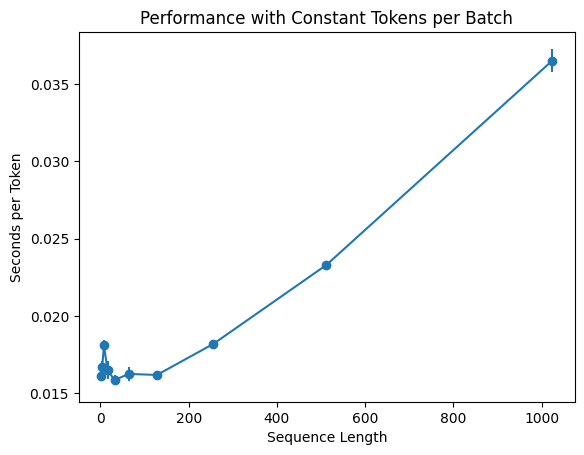

In [ ]:
import time
import numpy as np

def measure_performance(sequence_length, tokens_per_batch=8192, N=3):
    batch_size = tokens_per_batch // sequence_length
    inputs = MyInputs(dataset[2000:-1-sequence_length], sequence_length)
    labels = MyInputs(dataset[2001:-sequence_length], sequence_length)

    tok_per_sec_list = []
    for _ in range(N):
        t0 = time.time()
        for i in range(50):
            indexes = torch.randint(0, len(inputs)-sequence_length, (batch_size,))
            
            pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
            loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        tok_per_sec = sequence_length * batch_size * 50 / (time.time() - t0) / 1e3
        tok_per_sec_list.append(tok_per_sec)

    mean_tok_per_sec = np.mean(tok_per_sec_list).item()
    std_tok_per_sec = np.std(tok_per_sec_list).item()
    return mean_tok_per_sec, std_tok_per_sec

sequence_lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
time_data = []
time_data_std = []

for sequence_length in sequence_lengths:
    mean_tok_per_sec, std_tok_per_sec = measure_performance(sequence_length)
    time_data.append(1 / mean_tok_per_sec)  # Convert to seconds per token
    time_data_std.append(std_tok_per_sec / (mean_tok_per_sec ** 2))  # Convert to seconds per token

plt.errorbar(sequence_lengths, time_data, yerr=time_data_std, fmt='-o')
plt.xlabel('Sequence Length')
plt.ylabel('Seconds per Token')
plt.title('Performance with Constant Tokens per Batch')
plt.show()

# # using bad hyperparameters

# bad_sequence_lengths = [s + 1 for s in sequence_lengths[:7]]

# bad_time_data = []
# for sequence_length in bad_sequence_lengths:
#     mean_tok_per_sec, std_tok_per_sec = measure_performance(sequence_length)
#     bad_time_data.append(1 / mean_tok_per_sec)  # Convert to seconds per token

# plt.plot(sequence_lengths, time_data, '-o', label='Good Hyperparameters')
# plt.plot(bad_sequence_lengths, bad_time_data, '-o', label='Bad Hyperparameters')
# plt.xlabel('Sequence Length')
# plt.ylabel('Seconds per Token')
# plt.title('Performance with Constant Tokens per Batch')
# plt.legend()
# plt.show()

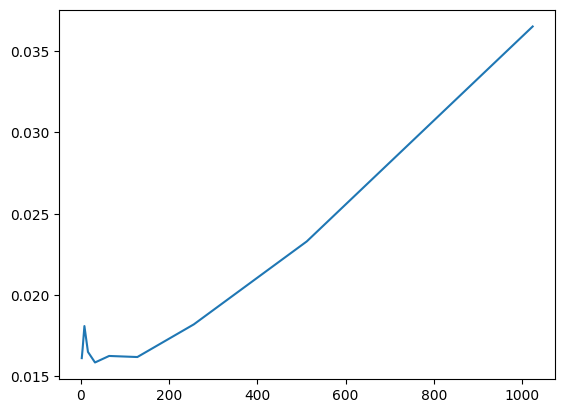

In [ ]:
plt.plot([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], time_data)

# Results
As you can see we can get really good loss with the transformer, this architecture should scale well up to GPT3.5 level performance with enough high quality data

In [ ]:
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))
print([p.numel() for p in model.parameters() if p.requires_grad])

Millions of parameters:  0.6
[32768, 2560, 16384, 128, 16384, 128, 16384, 128, 16384, 128, 32768, 256, 32768, 128, 128, 128, 128, 128, 16384, 128, 16384, 128, 16384, 128, 16384, 128, 32768, 256, 32768, 128, 128, 128, 128, 128, 16384, 128, 16384, 128, 16384, 128, 16384, 128, 32768, 256, 32768, 128, 128, 128, 128, 128, 16384, 128, 16384, 128, 16384, 128, 16384, 128, 32768, 256, 32768, 128, 128, 128, 128, 128, 128, 128, 32768, 256]


In [ ]:
model

Transformer(
  (embedding): Embedding(256, 64)
  (posemb): Embedding(400, 64)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (prenorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (att): Attention(
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (rvalues): Linear(in_features=64, out_features=64, bias=True)
      )
      (prenorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc): FullyConnected(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fcx): ModuleList(
          (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
        )
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (LinOut): Linear(in_features=64, out_features=256, bias=True)
)